# Making Multiple Markets

## Overview

By diversifying your assets and constructing a market-making book, you can achieve improved risk-adjusted returns through the effects of diversification. In this example, we will demonstrate how the statistics of your market-making portfolio change as you increase the number of assets for which you create markets.

To implement Grid Trading using the GLFT market-making model across multiple assets universally without needing to adjust parameters, a few modifications are required:

Order quantities vary between assets due to differences in price, trading volume, and liquidity in the order book. To backtest all at once, you need to normalize your order quantities and make adjustments accordingly.

In certain assets, market trades primarily take place at the best bid and offer levels. Since we only calculate our trading intensity when market trades match our quotes, you may not achieve adequate trading intensity to suit your trading intensity function in such cases. As a result, you'll need to explore alternative methods to determine your half spread and skew based on order arrival depths or you need to increase your reaction interval to get more deeper order arrival depth but it leads you to react delayed especially in a fast-moving market.

See how $adj_2$ is determined to normalize different order quantities.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

<div class="alert alert-info">

**Note:** The trading intensity in  `out` of `measure_trading_intensity` is incorrectly in half-tick units instead of tick units. Although this fix requires adjusting parameters in all related examples, the example is left unchanged to preserve existing results.

</div>

In [1]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord


@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]


@njit(cache=True)
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2


@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = np.divide(w * sxy - sx * sy, w * sx2 - sx**2)
    intercept = np.divide(sy - slope * sx, w)
    return slope, intercept


@njit
def gridtrading_glft_mm(hbt, recorder, order_qty):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = grid_num * order_qty
    adj2 = 1 / max_position
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = max(trade_price_tick - mid_price_tick, depth)
                else:
                    depth = max(mid_price_tick - trade_price_tick, depth)
            arrival_depth[t] = depth
        
        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = min(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = max(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)
        
        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        recorder.record(hbt)

The order quantity is determined to be equivalent to a notional value of $100.

In [2]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/feed_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)

    gridtrading_glft_mm(hbt, recorder.recorder, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_glft_mm_{}.npz'.format(asset_name))

By utilizing multiprocessing, backtesting of multiple assets can be conducted simultaneously.

In [3]:
%%capture
import json

from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets = json.load(f)

with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

In [4]:
import polars as pl
from hftbacktest.stats import LinearAssetRecord

equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_glft_mm_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

You can see the equity curve of individual assets and notice how combining multiple assets can lead to a smoother equity curve, thereby enhancing risk-adjusted returns.

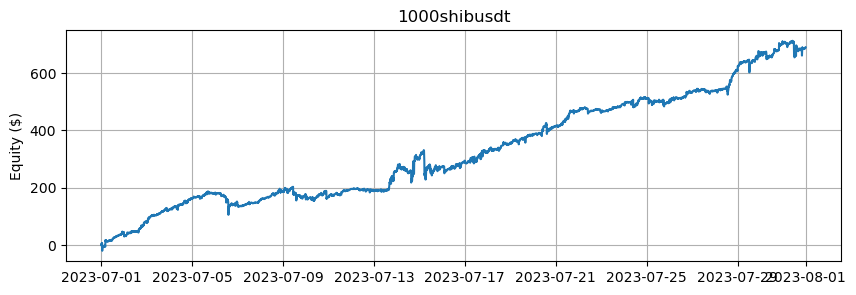

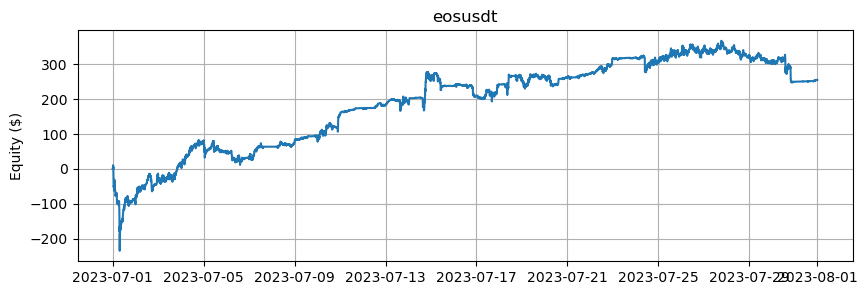

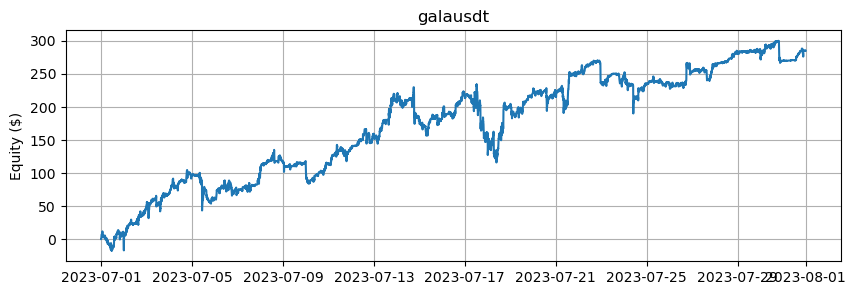

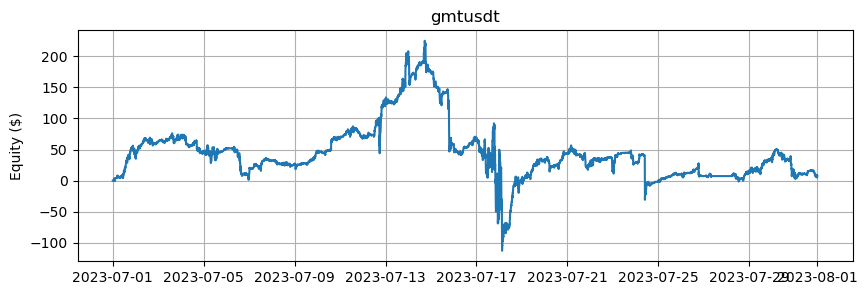

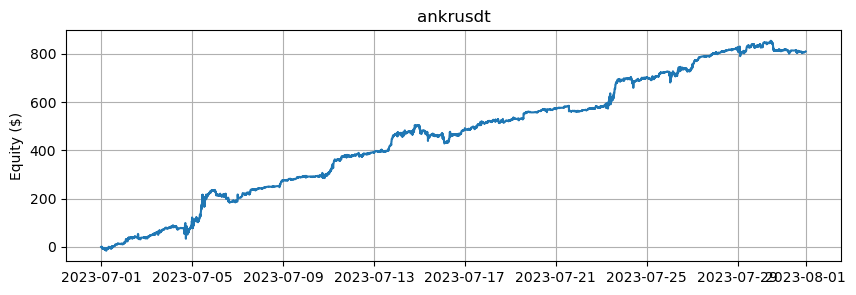

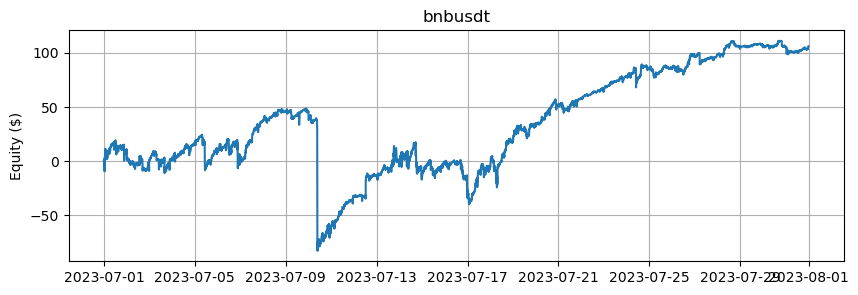

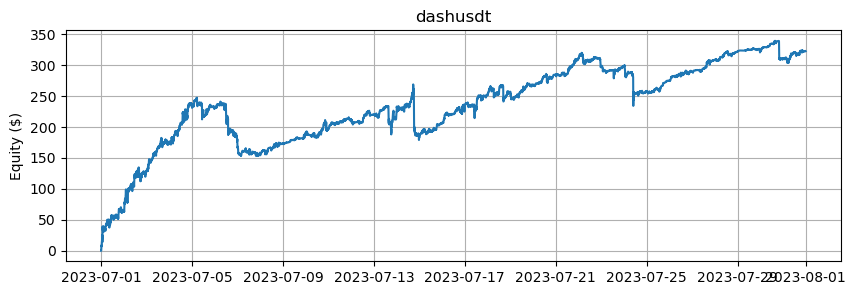

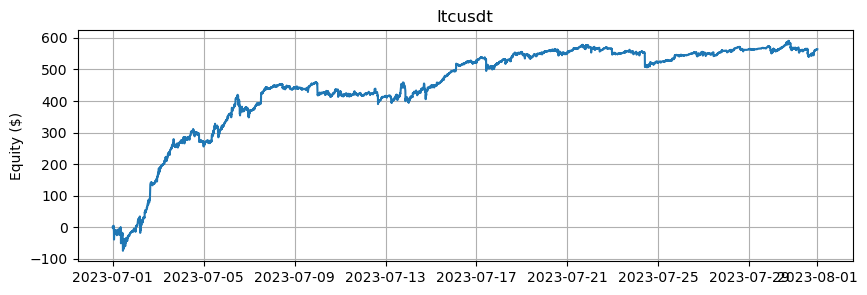

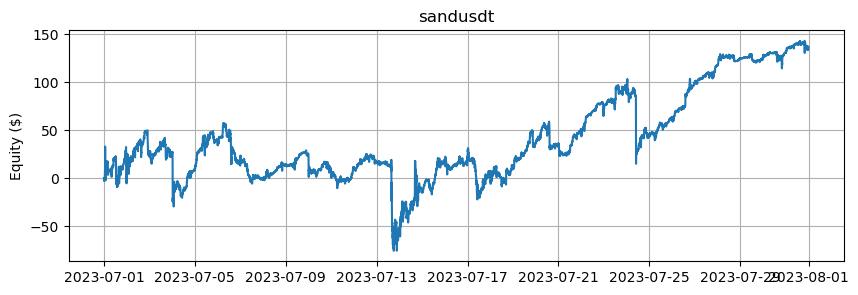

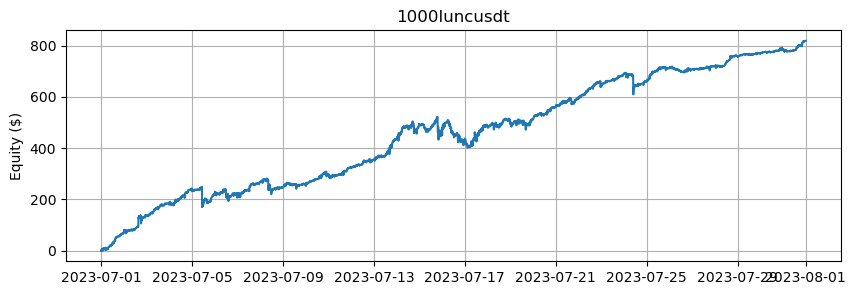

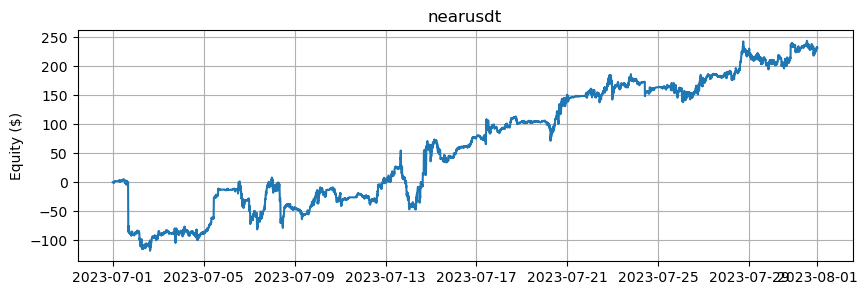

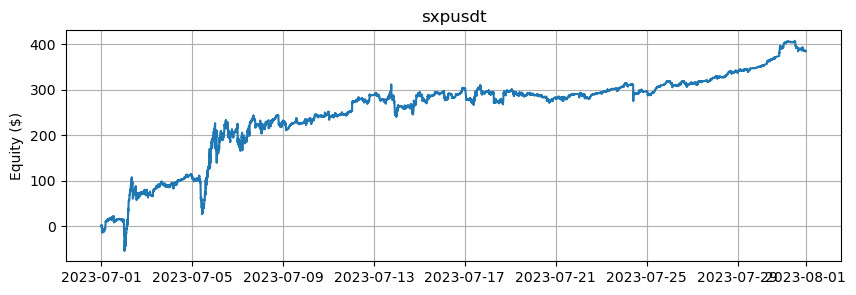

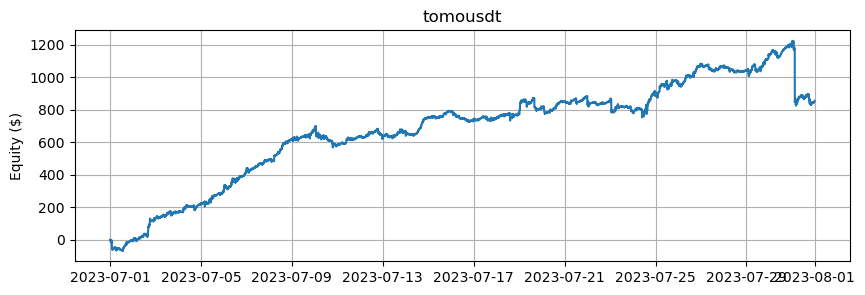

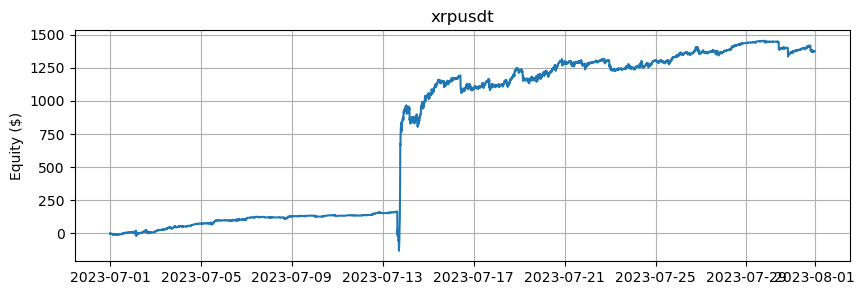

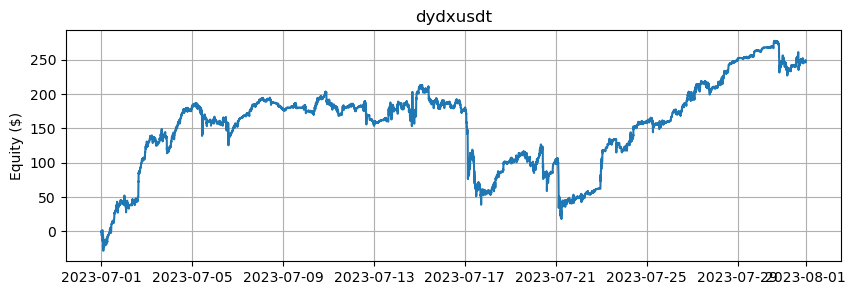

In [5]:
from matplotlib import pyplot as plt

for i, asset_name in enumerate(assets.keys()):
    plt.figure(i, figsize=(10, 3))
    plt.plot(equity_values[asset_name]['timestamp'], equity_values[asset_name]['equity'])
    plt.grid()
    plt.title(asset_name)
    plt.ylabel('Equity ($)')

This presents an equity curve based on the number of assets, which are altcoins excluding BTC and ETH.

Text(0, 0.5, 'Cumulative Returns (%)')

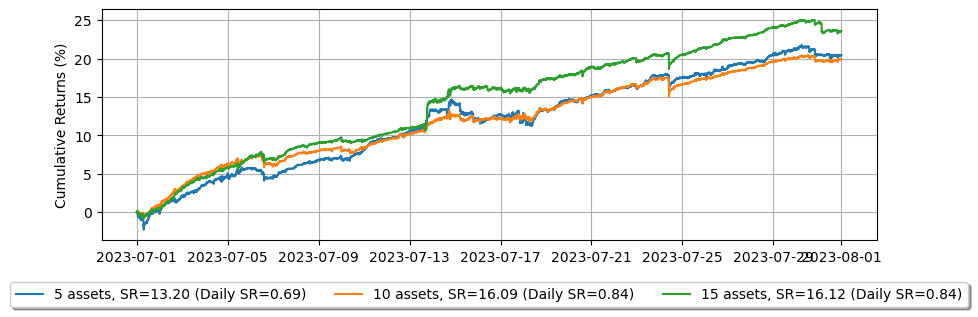

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 2_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

## Impact of Order Latency

When applying amplified feed latency, you can observe a decrease in performance due to the effects of latency.

In [7]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/amp_feed_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gridtrading_glft_mm(hbt, recorder.recorder, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_glft_mm_lat1_{}.npz'.format(asset_name))

In [8]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

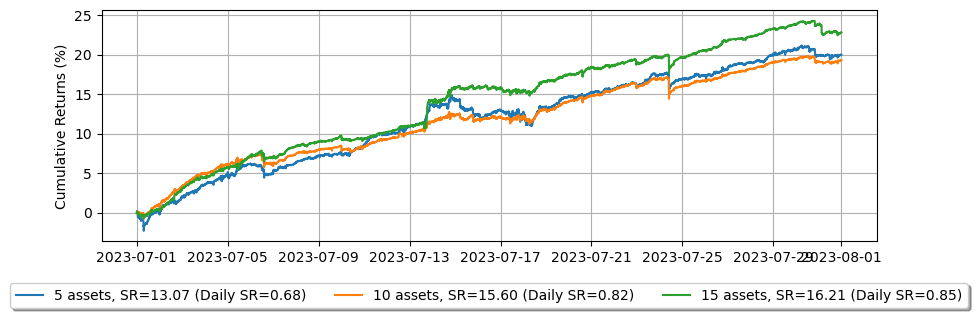

In [9]:
equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_glft_mm_lat1_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 2_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

When actual historical order latency is applied, the performance may deteriorate further compared to when amplified feed latency is used.

In [10]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gridtrading_glft_mm(hbt, recorder.recorder, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_glft_mm_lat2_{}.npz'.format(asset_name))

In [11]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

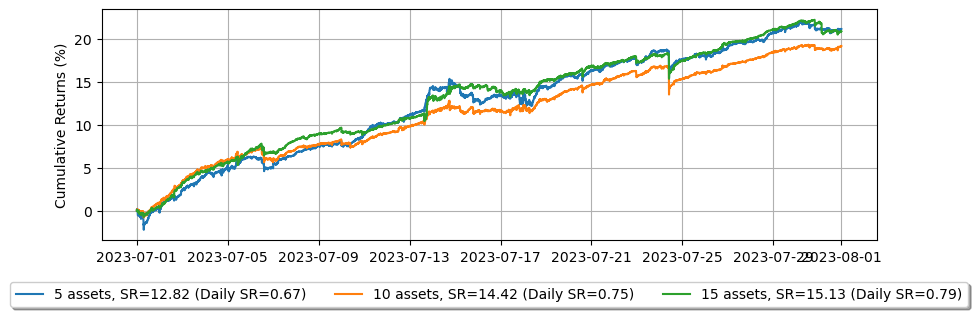

In [12]:
equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_glft_mm_lat2_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 2_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

Therefore, understanding your order latency is crucial to achieving more precise backtest results. This understanding underscores the importance of latency reduction for market makers or high-frequency traders. This is why crypto exchanges not only offer maker rebates but also provide low-latency infrastructure to eligible market makers.

## Simpler model

So far, we only cover $\xi>0$ case, but $\xi=0$ case would be more simple and appropriate in practice especially in cryptocurrencies.

Revisit the equations (4.6) and (4.7) in [Optimal market making](https://arxiv.org/abs/1605.01862) and explore how they can be applied to real-world scenarios.

The optimal bid quote depth, $\delta^{b*}_{approx}$, and ask quote depth, $\delta^{a*}_{approx}$, are derived from the fair price as follows in the case of $\xi=0$:

\begin{align}
\delta^{b*}_{approx}(q) = {1 \over k} + {{2q + \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.6}\tag{4.6} \\
\delta^{a*}_{approx}(q) = {1 \over k} - {{2q - \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.7}\tag{4.7}
\end{align}

Let's introduce $c_1$ and $c_2$ and define them by extracting the volatility 𝜎 from the square root as same as before:

\begin{align}
c_1 = {1 \over k} \\
c_2 = \sqrt{{{\gamma e} \over {2A\Delta k}}}
\end{align}

Now we can rewrite equations (4.6) and (4.7) as follows:

\begin{align}
\delta^{b*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 + q \sigma c_2 \\
\delta^{a*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 - q \sigma c_2
\end{align}

It's more concise and only need to adjust $\gamma$ and its effect is more straightforward.

In [13]:
@njit(cache=True)
def compute_coeff_simplified(gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = inv_k
    c2 = np.sqrt(np.divide(gamma * np.exp(1), 2 * A * delta * k))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, recorder, gamma, order_qty):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    delta = 1
    
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size
                
                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = max(trade_price_tick - mid_price_tick, depth)
                else:
                    depth = max(mid_price_tick - trade_price_tick, depth)
            arrival_depth[t] = depth
        
        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff_simplified(gamma, delta, A, k)
        
        half_spread_tick = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = position / order_qty
        
        reservation_price_tick = mid_price_tick - skew * normalized_position

        bid_price_tick = min(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = max(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)
        
        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        recorder.record(hbt)

In [14]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gamma = 0.00005
    gridtrading_glft_mm(hbt, recorder.recorder, gamma, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_simple_glft_mm1_{}.npz'.format(asset_name))

In [15]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

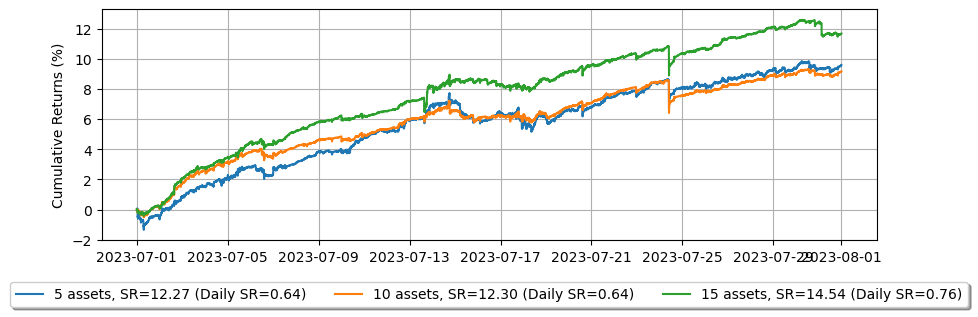

In [16]:
equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_simple_glft_mm1_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 5_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

In [17]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gamma = 0.001
    gridtrading_glft_mm(hbt, recorder.recorder, gamma, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_simple_glft_mm2_{}.npz'.format(asset_name))

In [18]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

You can observe a more straight line in the equity curve with higher $\gamma$, which induces greater skew. However, it also experiences more severe drawdowns in fast-moving markets. Additionally, because of the higher skew, profits are diminished as there's a greater tendency to close the position.

Text(0, 0.5, 'Cumulative Returns (%)')

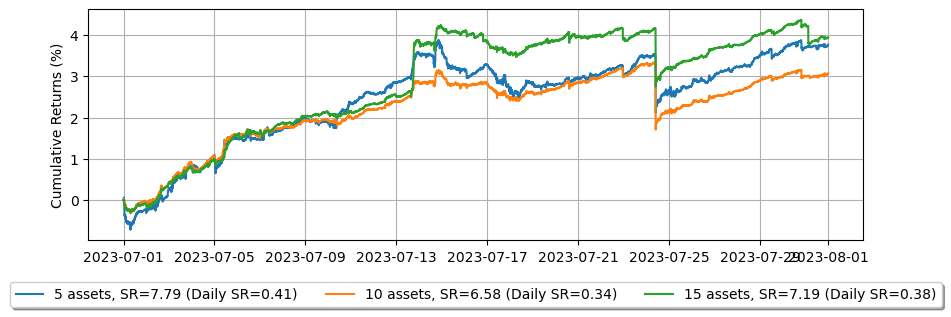

In [19]:
equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_simple_glft_mm2_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 5_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

## A Case for More Assets

The more assets you make a market for, the better risk-adjusted return you achieve. This effect becomes dramatically evident.

In [20]:
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230730_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230731, 20230732)]
    )
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230731, 20230732)])
            .initial_snapshot('data/{}_20230730_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model(2.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gamma = 0.00005
    gridtrading_glft_mm(hbt, recorder.recorder, gamma, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_simple_glft_mm3_{}.npz'.format(asset_name))

In [21]:
%%capture
with open('assets2.json', 'r') as f:
    assets = json.load(f)
    
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

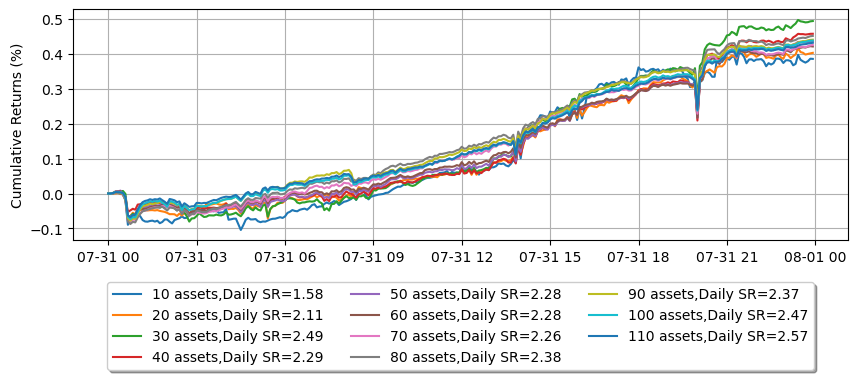

In [22]:
equity_values = {}
sr_values = {}

np.seterr(divide='ignore', invalid='ignore')

for asset_name in assets.keys():
    data = np.load('stats/gridtrading_simple_glft_mm3_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])

    pnl = equity['equity'].diff()
    sr = np.divide(pnl.mean(), pnl.std())

    equity_values[asset_name] = equity
    sr_values[asset_name] = sr

sr_m = np.nanmean(list(sr_values.values()))
sr_s = np.nanstd(list(sr_values.values()))

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
asset_number = 0
net_equity = None
for i, (equity, sr) in enumerate(zip(equity_values.values(), sr_values.values())):
    # There are some assets that aren't working within this scheme.
    # This might be because the order arrivals don't follow a Poisson distribution that this model assumes.
    # As a result, it filters out assets whose SR falls outside -0.5 sigma.
    if (sr - sr_m) / sr_s > -0.5:
        asset_number += 1
        if net_equity is None:
            net_equity = equity.clone()
        else:
            net_equity = net_equity.select(
                'timestamp',
                (pl.col('equity') + equity['equity']).alias('equity')
            )

        if asset_number % 10 == 0:
            # 5_000 is capital for each trading asset.
            net_equity_ = net_equity['equity'] / asset_number / 5_000 
            pnl = net_equity_.diff()
            # Since the P&L is resampled at a 5-minute interval
            sr = pnl.mean() / pnl.std() * np.sqrt(24 * 60 / 5)
            legend.append('{} assets,Daily SR={:.2f}'.format(asset_number, sr))
            plt.plot(net_equity['timestamp'], net_equity_ * 100)
    
plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')